In [ ]:
pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [ ]:
tf.config.set_visible_devices([], 'GPU')  # Disable any GPUs initially
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')  # Enable the first GPU
    print("GPU Enabled:", physical_devices[0])
else:
    print("No GPU available.")

No GPU available.


In [ ]:
# Define the number of random layers
n_layers = 1

# Define the quantum circuit
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def circuit(phi, weights):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    qml.templates.RandomLayers(weights, wires=list(range(4)))
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            rand_weights = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
            q_results = circuit(
                [
                    image[j, k],
                    image[j, k + 1],
                    image[j + 1, k],
                    image[j + 1, k + 1]
                ],
                rand_weights
            )
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
# Load and preprocess a subset of the MNIST dataset (60 training images and 10 test images)
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Use a subset of 60 training images and 10 test images
train_images = train_images[:8000] / 255.0
train_labels = train_labels[:8000]
test_images = test_images[:2000] / 255.0
test_labels = test_labels[:2000]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# Preprocess images for quantum processing
q_train_images = np.array([quanv(img) for img in train_images])
q_test_images = np.array([quanv(img) for img in test_images])

In [ ]:
# Build the classical model
def MyModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(14, 14, 4)),
        keras.layers.Dense(128, activation='relu'), #non linearity
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax') #normalization
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Train the model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=2000,  # Reduce batch size due to smaller dataset
    epochs=100,
    verbose=2
)

Epoch 1/100
4/4 - 3s - loss: 2.6477 - accuracy: 0.1114 - val_loss: 2.3306 - val_accuracy: 0.1570 - 3s/epoch - 670ms/step
Epoch 2/100
4/4 - 0s - loss: 2.2391 - accuracy: 0.2017 - val_loss: 2.1711 - val_accuracy: 0.2140 - 263ms/epoch - 66ms/step
Epoch 3/100
4/4 - 0s - loss: 2.0183 - accuracy: 0.3005 - val_loss: 1.9964 - val_accuracy: 0.3150 - 285ms/epoch - 71ms/step
Epoch 4/100
4/4 - 0s - loss: 1.8013 - accuracy: 0.4094 - val_loss: 1.8366 - val_accuracy: 0.4130 - 146ms/epoch - 36ms/step
Epoch 5/100
4/4 - 0s - loss: 1.5984 - accuracy: 0.5061 - val_loss: 1.6648 - val_accuracy: 0.4790 - 164ms/epoch - 41ms/step
Epoch 6/100
4/4 - 0s - loss: 1.4025 - accuracy: 0.5705 - val_loss: 1.4882 - val_accuracy: 0.5415 - 159ms/epoch - 40ms/step
Epoch 7/100
4/4 - 0s - loss: 1.2222 - accuracy: 0.6302 - val_loss: 1.3355 - val_accuracy: 0.5880 - 137ms/epoch - 34ms/step
Epoch 8/100
4/4 - 0s - loss: 1.0651 - accuracy: 0.6690 - val_loss: 1.2129 - val_accuracy: 0.6260 - 137ms/epoch - 34ms/step
Epoch 9/100
4/4 - 

In [ ]:
# Evaluate the model
test_loss, test_acc = q_model.evaluate(q_test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

63/63 - 0s - loss: 0.7181 - accuracy: 0.7910 - 261ms/epoch - 4ms/step

Test accuracy: 0.7910000085830688


In [ ]:
# Get predictions for the test data
predictions = q_model.predict(q_test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display original and predicted labels for 10 test data points
print("Original and Predicted Labels for 10 Test Data Points:")
for i in range(10):
    print(f"Data Point {i + 1}: Original Label - {test_labels[i]}, Predicted Label - {predicted_labels[i]}")


63/63 [==============================] - 0s 6ms/step
Original and Predicted Labels for 10 Test Data Points:
Data Point 1: Original Label - 7, Predicted Label - 7
Data Point 2: Original Label - 2, Predicted Label - 2
Data Point 3: Original Label - 1, Predicted Label - 1
Data Point 4: Original Label - 0, Predicted Label - 0
Data Point 5: Original Label - 4, Predicted Label - 4
Data Point 6: Original Label - 1, Predicted Label - 1
Data Point 7: Original Label - 4, Predicted Label - 9
Data Point 8: Original Label - 9, Predicted Label - 9
Data Point 9: Original Label - 5, Predicted Label - 6
Data Point 10: Original Label - 9, Predicted Label - 9


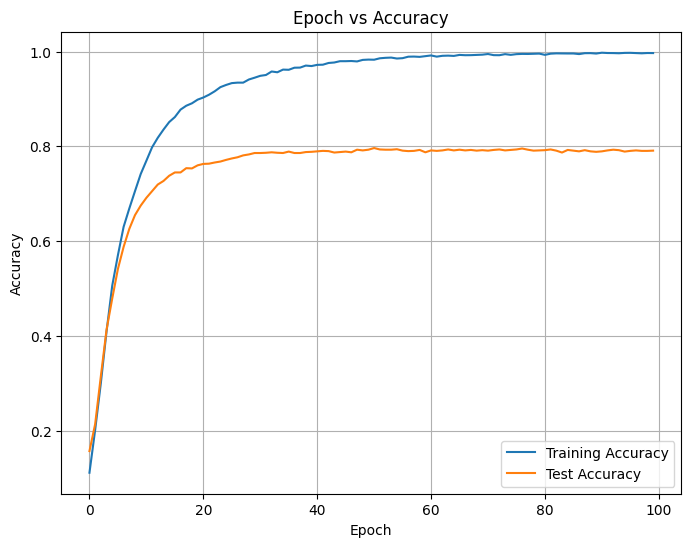

In [ ]:
import matplotlib.pyplot as plt

# Plotting epoch vs accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(q_history.history['accuracy'], label='Training Accuracy')
plt.plot(q_history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report based on true labels and predicted labels
def print_classification_report(true_labels, predicted_labels):
    cr = classification_report(true_labels, predicted_labels)
    print(cr)

# Get predictions for the test data
predictions = q_model.predict(q_test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Print classification report based on true labels and predicted labels
print("Classification Report:")
print_classification_report(test_labels, predicted_labels)


63/63 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       175
           1       0.86      0.94      0.90       234
           2       0.84      0.76      0.80       219
           3       0.78      0.77      0.78       207
           4       0.77      0.80      0.78       217
           5       0.69      0.72      0.70       179
           6       0.78      0.78      0.78       178
           7       0.82      0.78      0.80       205
           8       0.71      0.66      0.68       192
           9       0.72      0.75      0.74       194

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



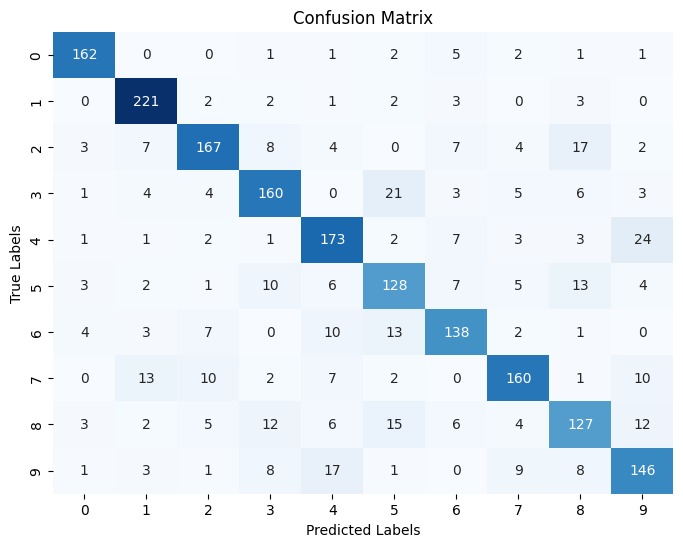

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix and print it
def calculate_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    return cm

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(confusion_mat)
